# Setup

In [1]:
import glob
import numpy as np
from copy import deepcopy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os
from random import randint
import cv2

In [2]:
def file_lines_to_list(path):
    # open txt file lines to a list
    with open(path) as f:
        content = f.readlines()
    # remove whitespace characters like `\n` at the end of each line
    content = [(x.strip()).split() for x in content]
    return content

def get_file_name(path):
    basename = os.path.basename(path)
    onlyname = os.path.splitext(basename)[0]
    return onlyname

# Calculate GT/TP and Draw Graphs

In [3]:
def calc_iou(gt_bbox, pred_bbox):
    '''
    This function takes the predicted bounding box and ground truth bounding box and 
    return the IoU ratio
    '''
    x_topleft_gt, y_topleft_gt, x_bottomright_gt, y_bottomright_gt = gt_bbox
    x_topleft_p, y_topleft_p, x_bottomright_p, y_bottomright_p = pred_bbox
    
    if (x_topleft_gt > x_bottomright_gt) or (y_topleft_gt > y_bottomright_gt):
        raise AssertionError("Ground Truth Bounding Box is not correct")
    if (x_topleft_p > x_bottomright_p) or (y_topleft_p > y_bottomright_p):
        raise AssertionError("Predicted Bounding Box is not correct")
        
    #if the GT bbox and predcited BBox do not overlap then iou=0
    if(x_bottomright_gt < x_topleft_p):      
        return 0.0
    if(y_bottomright_gt < y_topleft_p):        
        return 0.0
    if(x_topleft_gt > x_bottomright_p):      
        return 0.0
    if(y_topleft_gt > y_bottomright_p):
        return 0.0
    
    GT_bbox_area = (x_bottomright_gt - x_topleft_gt + 1) * (y_bottomright_gt - y_topleft_gt + 1)
    Pred_bbox_area = (x_bottomright_p - x_topleft_p + 1 ) * (y_bottomright_p - y_topleft_p + 1)
    
    x_top_left = np.max([x_topleft_gt, x_topleft_p])
    y_top_left = np.max([y_topleft_gt, y_topleft_p])
    x_bottom_right = np.min([x_bottomright_gt, x_bottomright_p])
    y_bottom_right = np.min([y_bottomright_gt, y_bottomright_p])
    
    intersection_area = (x_bottom_right - x_top_left + 1) * (y_bottom_right - y_top_left  + 1)
    
    union_area = (GT_bbox_area + Pred_bbox_area - intersection_area)
   
    return intersection_area/union_area

In [4]:
def process_single_image_results(gt_boxes, pred_boxes, iou_thr):

    detected_obj_boxes = []

    if len(pred_boxes) > 0 and len(gt_boxes) > 0:
    
        gt_idx_thr=[]
        pred_idx_thr=[]
        ious=[]

        for igb, gt_box in enumerate(gt_boxes):
            for ipb, pred_box in enumerate(pred_boxes):
                iou = calc_iou(gt_box, pred_box)

                if iou >= iou_thr:
                    detected_obj_boxes.append(gt_box)
    
    return detected_obj_boxes

In [5]:
# Non-maximum Suppression
def nms(dets, thresh):
    x1 = dets[:, 0]
    y1 = dets[:, 1]
    x2 = dets[:, 2]
    y2 = dets[:, 3]
    scores = dets[:, 4]

    areas = (x2 - x1 + 1) * (y2 - y1 + 1)
    order = scores.argsort()[::-1]

    keep = []
    nms_output = []
    while order.size > 0:
        i = order[0]
        keep.append(i)
        nms_output.append(dets[i])
        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])

        w = np.maximum(0.0, xx2 - xx1 + 1)
        h = np.maximum(0.0, yy2 - yy1 + 1)
        inter = w * h
        ovr = inter / (areas[i] + areas[order[1:]] - inter)

        inds = np.where(ovr <= thresh)[0]
        order = order[inds + 1]

    return keep, nms_output

## Print Detection and Find Duplicated Detection

In [226]:
gt_path = glob.glob("./graphs/bdd100k_person_GT/*.txt")

all_gt_boxes = []
for path in gt_path:
    contents = file_lines_to_list(path)
    for content in contents:
        all_gt_boxes.append([int(content[1]), int(content[2]), int(content[3]), int(content[4])])
        
print("Num Objects:", len(all_gt_boxes), "Num Images:", len(gt_path))

Num Objects: 13262 Num Images: 3220


In [155]:
# index = randint(0, len(gt_path)-1)
# path = gt_path[index]
# img_name = get_file_name(path)

# # BDD100K
# img = plt.imread(f"../datasets/bdd100k/bdd100k/bdd100k/images/100k/val/{img_name}.jpg")

# gt_boxes = file_lines_to_list(f"./graphs/bdd100k_person_GT/{img_name}.txt")
# det_boxes = file_lines_to_list(f"./graphs/{result_file_name}/{img_name}.txt")
# #######

# # WAYMO
# img = plt.imread(f"../datasets/waymo/data/val/{img_name}.jpg")

# gt_boxes = file_lines_to_list(f"./graphs/waymo_90_105_(60_70)_GT/{img_name}.txt")
# det_boxes = file_lines_to_list(f"./graphs/{result_file_name}/{img_name}.txt")
# #######

# print(len(gt_boxes), len(det_boxes))

# dummy = img.copy()

# for obj in gt_boxes:
#     cv2.rectangle(dummy, (int(obj[1]), int(obj[2])), (int(obj[3]), int(obj[4])), (255, 0, 0), thickness = 2)
    
# for obj in det_boxes:
#     cv2.rectangle(dummy, (int(obj[2]), int(obj[3])), (int(obj[4]), int(obj[5])), (0, 255, 0), thickness = 2)
#     cv2.putText(dummy, str(obj[1]), (int(obj[2])-10, int(obj[3])-10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
                                                            
# plt.figure(figsize = (15, 10))
# plt.imshow(dummy)
# plt.show()

In [201]:
# iou_list = []
# score_list = []
# index_list = []

# if len(det_boxes_list) > 0:
#     for gt_box in gt_boxes_list:
#         iou_list_i = []
#         for det_box in det_boxes_list:
#             array_gt = [int(gt_box[1]), int(gt_box[2]), int(gt_box[3]), int(gt_box[4])]
#             array_det = [int(det_box[2]), int(det_box[3]), int(det_box[4]), int(det_box[5])]

#             iou = calc_iou(array_gt, array_det)

#             iou_list_i.append(iou)

#         max_iou_i = np.amax(iou_list_i)
#         index_max = np.argmax(iou_list_i)

#         iou_list.append(max_iou_i)
#         score_list.append(det_boxes_list[index_max][1])
#         index_list.append(index_max)

# else:
#     for gt_box in gt_boxes_list:
#         iou_list.append(0)
        
# print(gt_boxes_list)
# print("IoU", iou_list)
# print("Score", score_list)
# print("Index", index_list)

In [80]:
result_file_name = "subsampling_608_304_epoch_49_no_margin"
index = randint(0, len(gt_path)-1)
print(index)

path = gt_path[index]
img_name = get_file_name(path)
print(img_name)

# BDD100K
img = plt.imread(f"../datasets/bdd100k/bdd100k/bdd100k/images/100k/val/{img_name}.jpg")

gt_boxes = file_lines_to_list(f"./graphs/bdd100k_person_GT/{img_name}.txt")
det_boxes = file_lines_to_list(f"./graphs/{result_file_name}/{img_name}.txt")
#######

min_width = 10
min_height = 30

if len(det_boxes) > 0:
    det_list = []
    for det_box in det_boxes:
        if int(det_box[5]) - int(det_box[3]) >= min_height and int(det_box[4]) - int(det_box[2]) >= min_width:
            det_list.append([int(det_box[2]), int(det_box[3]), int(det_box[4]), int(det_box[5]), float(det_box[1])])

det_array = np.array(det_list)
index, nms_output = nms(det_array, 0.7)
print(len(det_list), len(nms_output))

130
b29f09ea-911177ce
45 42


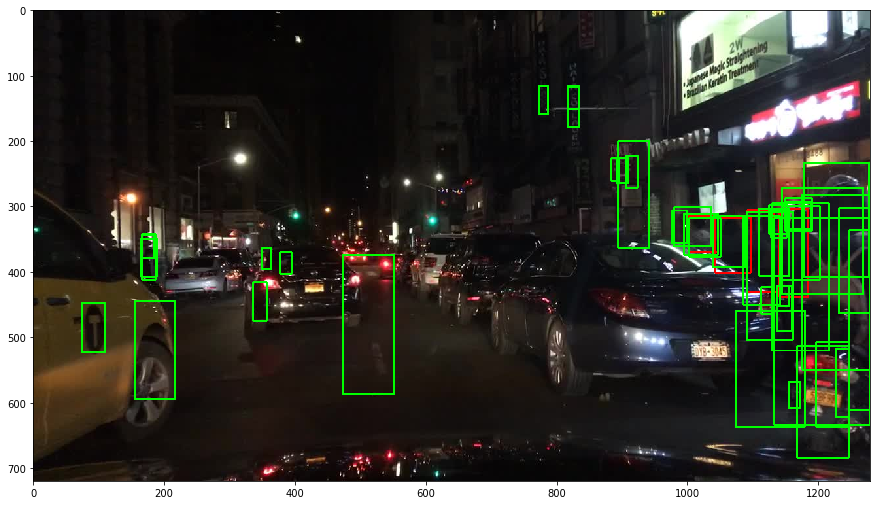

In [81]:
img_dummy = img.copy()

for obj in gt_boxes:
    cv2.rectangle(img_dummy, (int(obj[1]), int(obj[2])), (int(obj[3]), int(obj[4])), (255, 0, 0), thickness = 2)
    
# for obj in det_list:
for obj in det_array:
    cv2.rectangle(img_dummy, (int(obj[0]), int(obj[1])), (int(obj[2]), int(obj[3])), (0, 255, 0), thickness = 2)
                                                            
plt.figure(figsize = (15, 10))
plt.imshow(img_dummy)
plt.show()

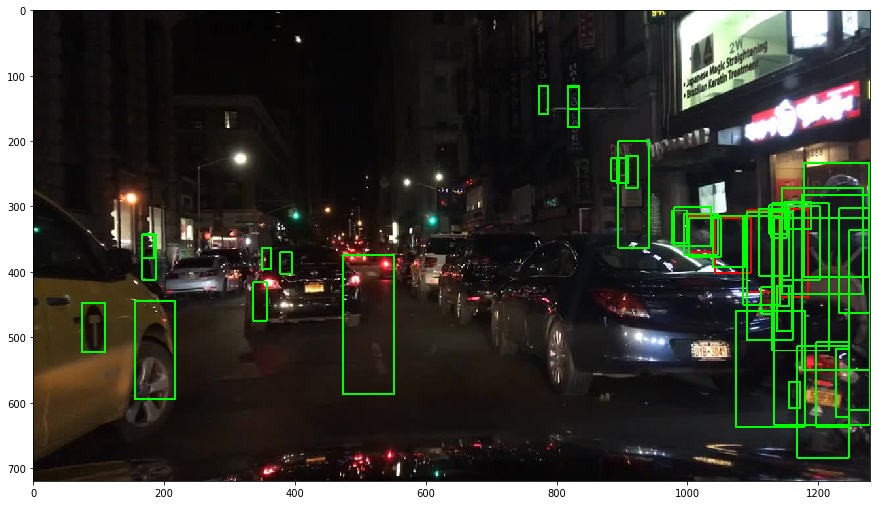

In [82]:
img_dummy = img.copy()

for obj in gt_boxes:
    cv2.rectangle(img_dummy, (int(obj[1]), int(obj[2])), (int(obj[3]), int(obj[4])), (255, 0, 0), thickness = 2)
    
for obj in nms_output:
    cv2.rectangle(img_dummy, (int(obj[0]), int(obj[1])), (int(obj[2]), int(obj[3])), (0, 255, 0), thickness = 2)
                                                            
plt.figure(figsize = (15, 10))
plt.imshow(img_dummy)
plt.show()

# Delete Incorrect Files

In [6]:
gt_path = glob.glob("./graphs/bdd_small_person_GT/*.txt")

gt_names = []
for path in gt_path:
    name = get_file_name(path)
    gt_names.append(name)
        
print("Num Images:", len(gt_names))

Num Images: 2496


In [9]:
det_path = glob.glob("./graphs/subsampling_smallyolo31_608_304_2stage_epoch_45/*.txt")

for path in det_path:
    filename = get_file_name(path)
    if filename not in gt_names:
        os.remove(path)

# Post-Processing

In [250]:
result_file_name = "subsampling_608_epoch_45"
new_result_file_name = f"{result_file_name}_update1"

min_width = 10
min_height = 30

i=0
for path in gt_path:
    img_name = get_file_name(path)

    gt_boxes = file_lines_to_list(f"./graphs/bdd100k_person_GT/{img_name}.txt")
    det_boxes = file_lines_to_list(f"./graphs/{result_file_name}/{img_name}.txt")

    if len(det_boxes) > 0:
        det_list = []
        for det_box in det_boxes:
            if int(det_box[5]) - int(det_box[3]) >= min_height and int(det_box[4]) - int(det_box[2]) >= min_width:
                det_list.append([int(det_box[2]), int(det_box[3]), int(det_box[4]), int(det_box[5]), float(det_box[1])])

        if len(det_list) > 0:
            det_array = np.array(det_list)
            index, nms_output = nms(det_array, 0.7)  
    
    else:
        nms_output = []
        
    # Create and write out a text file:
    text_file = open(f"./post-processing/{new_result_file_name}/{img_name}.txt", "w+")

    for box in nms_output:
        print("person", box[4], box[0], box[1], box[2], box[3], file=text_file)                     
    text_file.close()
#     i+=1
#     print(i, len(gt_path))

# Analyse Multi-Stage Detection

In [73]:
gt_path = glob.glob("./graphs/bdd100k_person_GT/*.txt")

all_gt_boxes = []
for path in gt_path:
    contents = file_lines_to_list(path)
    for content in contents:
        # if content[0] == "person":
        # all_gt_boxes.append([float(content[2]), float(content[3]), float(content[4]), float(content[5])])
        all_gt_boxes.append([float(content[1]), float(content[2]), float(content[3]), float(content[4])])
        
print("Num Objects:", len(all_gt_boxes), "Num Images:", len(gt_path))

Num Objects: 13262 Num Images: 3220


1280
bb655f15-825903ad


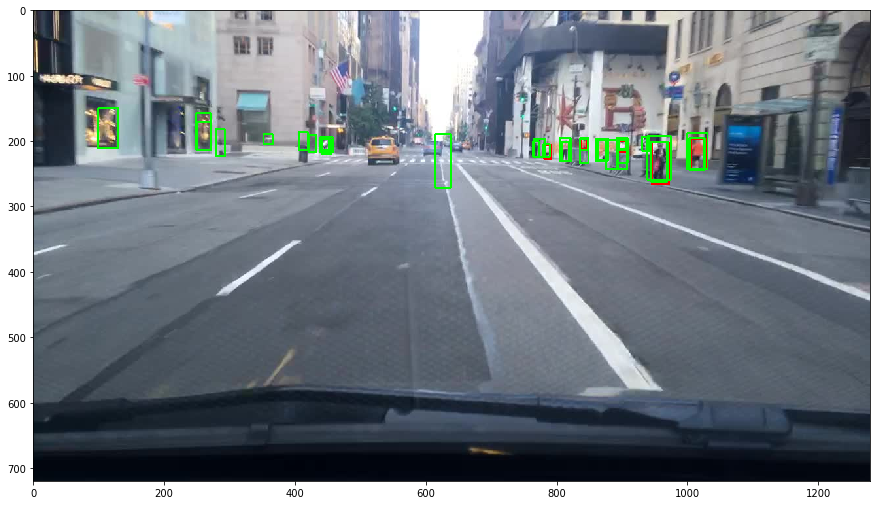

In [148]:
# Process Original Output

result_file_name = "subsampling608_20_100_resyolo_bdd_3stage_epoch_41"
index = randint(0, len(gt_path)-1)
print(index)

path = gt_path[index]
img_name = get_file_name(path)
print(img_name)

# img_name = "b4607812-48ed5dcb"
path = f"./graphs/{result_file_name}/{img_name}.txt"

# BDD100K
img = plt.imread(f"../datasets/bdd100k/bdd100k/bdd100k/images/100k/val/{img_name}.jpg")

det_list = []
contents = file_lines_to_list(path)

for content in contents:
    if content[0] == "person":
        det_list.append([float(content[2]), float(content[3]), float(content[4]), float(content[5]), float(content[1])])
        
gt_boxes = file_lines_to_list(f"./graphs/bdd100k_person_GT/{img_name}.txt")

img_dummy = img.copy()

for obj in gt_boxes:
    cv2.rectangle(img_dummy, (int(obj[1]), int(obj[2])), (int(obj[3]), int(obj[4])), (255, 0, 0), thickness = 2)
    
for obj in det_list:
    cv2.rectangle(img_dummy, (int(obj[0]), int(obj[1])), (int(obj[2]), int(obj[3])), (0, 255, 0), thickness = 2)
                                                            
plt.figure(figsize = (15, 10))
plt.imshow(img_dummy)
plt.show()

33 22


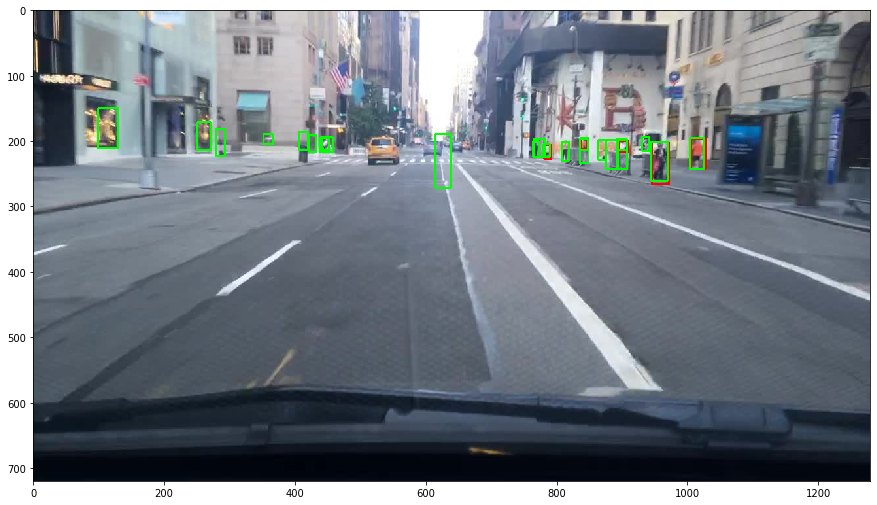

In [149]:
# Non-maximun Suppression

det_array = np.array(det_list)
index, nms_output = nms(det_array, 0.5)
print(len(det_list), len(nms_output))

img_dummy = img.copy()

for obj in gt_boxes:
    cv2.rectangle(img_dummy, (int(obj[1]), int(obj[2])), (int(obj[3]), int(obj[4])), (255, 0, 0), thickness = 2)
    
for obj in nms_output:
    cv2.rectangle(img_dummy, (int(obj[0]), int(obj[1])), (int(obj[2]), int(obj[3])), (0, 255, 0), thickness = 2)
                                                            
plt.figure(figsize = (15, 10))
plt.imshow(img_dummy)
plt.show()

33 22
15 13


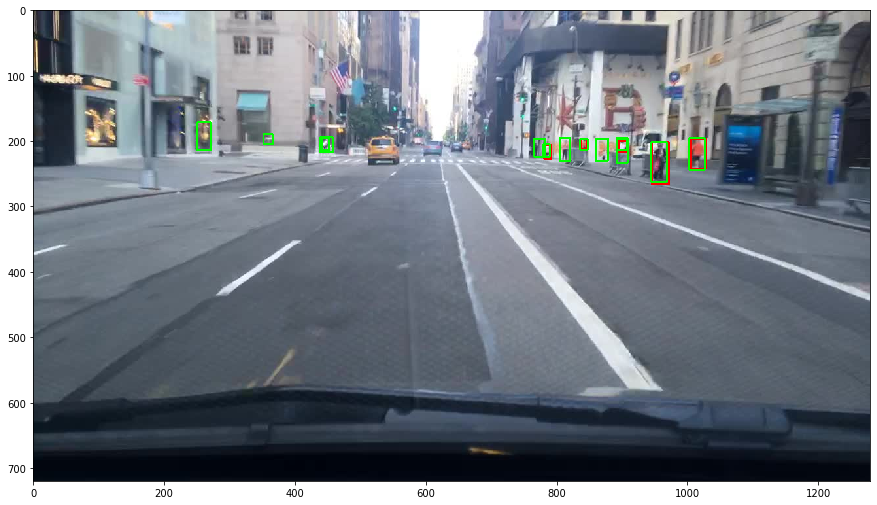

In [150]:
# Post-processing

current_stage = 0
det_list_2 = []
for content in contents:   
    if content[0] != "person":
        current_stage += 1
        
    else: 
        width = int(content[4]) - int(content[2])
        height = int(content[5]) - int(content[3])
    
        if current_stage == 1:    # 608
            if width >= 10 and height >= 15 and width <= 50 and height <= 150:
                det_list_2.append([int(content[2]), int(content[3]), int(content[4]), int(content[5]), float(content[1])])
        if current_stage == 2:    # 304
            if width >= 7 and height >= 10 and width <= 15 and height <= 20:
                det_list_2.append([int(content[2]), int(content[3]), int(content[4]), int(content[5]), float(content[1])])
        if current_stage == 3:    # 1280
            if width >= 40 and height >= 100:
                det_list_2.append([int(content[2]), int(content[3]), int(content[4]), int(content[5]), float(content[1])])


det_array_2 = np.array(det_list_2)
index, nms_output_2 = nms(det_array_2, 0.5)
print(len(det_list), len(nms_output))
print(len(det_list_2), len(nms_output_2))

img_dummy = img.copy()

for obj in gt_boxes:
    cv2.rectangle(img_dummy, (int(obj[1]), int(obj[2])), (int(obj[3]), int(obj[4])), (255, 0, 0), thickness = 2)
    
post_process = nms_output_2
for obj in post_process:
    cv2.rectangle(img_dummy, (int(obj[0]), int(obj[1])), (int(obj[2]), int(obj[3])), (0, 255, 0), thickness = 2)
                                                            
plt.figure(figsize = (15, 10))
plt.imshow(img_dummy)
plt.show()

In [151]:
# Post-processing Run 
gt_path = glob.glob("./graphs/bdd100k_person_GT/*.txt")

# all_gt_boxes = []
# for path in gt_path:
#     contents = file_lines_to_list(path)
#     for content in contents:
#         if content[0] == "person":
#             all_gt_boxes.append([int(content[2]), int(content[3]), int(content[4]), int(content[5])])
        
# print("Num Objects:", len(all_gt_boxes), "Num Images:", len(gt_path))

result_file_name = "subsampling608_20_100_resyolo_bdd_3stage_epoch_41"
new_result_file_name = f"{result_file_name}_update2"

# min_width = 10
# min_height = 30

i=0
for path in gt_path:
    img_name = get_file_name(path)

    contents = file_lines_to_list(f"./graphs/{result_file_name}/{img_name}.txt")
    
    if len(contents) > 0:
        current_stage = 0
        det_list_2 = []
        for content in contents:   
            if content[0] != "person":
                current_stage += 1

            else: 
                width = int(content[4]) - int(content[2])
                height = int(content[5]) - int(content[3])

#                 if current_stage == 1:   
#                     if width >= 7 and height >= 10:
#                         det_list_2.append([int(content[2]), int(content[3]), int(content[4]), int(content[5]), float(content[1])])
#                 if current_stage == 2:  
#                     if width >= 10 and height >= 30:
#                         det_list_2.append([int(content[2]), int(content[3]), int(content[4]), int(content[5]), float(content[1])])
#                 if current_stage == 3:  
#                     if width >= 30 and height >= 30:
#                         det_list_2.append([int(content[2]), int(content[3]), int(content[4]), int(content[5]), float(content[1])])
   
                if current_stage == 1:    # 608
                    if width >= 10 and height >= 15 and width <= 50 and height <= 150:
                        det_list_2.append([int(content[2]), int(content[3]), int(content[4]), int(content[5]), float(content[1])])
                if current_stage == 2:    # 304
                    if width >= 7 and height >= 10 and width <= 15 and height <= 20:
                        det_list_2.append([int(content[2]), int(content[3]), int(content[4]), int(content[5]), float(content[1])])
                if current_stage == 3:    # 1280
                    if width >= 40 and height >= 100:
                        det_list_2.append([int(content[2]), int(content[3]), int(content[4]), int(content[5]), float(content[1])])


        if len(det_list_2) > 0:
            det_array_2 = np.array(det_list_2)
            index, nms_output_2 = nms(det_array_2, 0.5)
        else:
            nms_output_2 = []
    else:
        nms_output_2 = []
        
    # Create and write out a text file:
    text_file = open(f"./post-processing/{new_result_file_name}/{img_name}.txt", "w+")

    for box in nms_output_2:
        print("person", box[4], box[0], box[1], box[2], box[3], file=text_file)                     
    text_file.close()
    i+=1
    print(i, len(gt_path))

1 3220
2 3220
3 3220
4 3220
5 3220
6 3220
7 3220
8 3220
9 3220
10 3220
11 3220
12 3220
13 3220
14 3220
15 3220
16 3220
17 3220
18 3220
19 3220
20 3220
21 3220
22 3220
23 3220
24 3220
25 3220
26 3220
27 3220
28 3220
29 3220
30 3220
31 3220
32 3220
33 3220
34 3220
35 3220
36 3220
37 3220
38 3220
39 3220
40 3220
41 3220
42 3220
43 3220
44 3220
45 3220
46 3220
47 3220
48 3220
49 3220
50 3220
51 3220
52 3220
53 3220
54 3220
55 3220
56 3220
57 3220
58 3220
59 3220
60 3220
61 3220
62 3220
63 3220
64 3220
65 3220
66 3220
67 3220
68 3220
69 3220
70 3220
71 3220
72 3220
73 3220
74 3220
75 3220
76 3220
77 3220
78 3220
79 3220
80 3220
81 3220
82 3220
83 3220
84 3220
85 3220
86 3220
87 3220
88 3220
89 3220
90 3220
91 3220
92 3220
93 3220
94 3220
95 3220
96 3220
97 3220
98 3220
99 3220
100 3220
101 3220
102 3220
103 3220
104 3220
105 3220
106 3220
107 3220
108 3220
109 3220
110 3220
111 3220
112 3220
113 3220
114 3220
115 3220
116 3220
117 3220
118 3220
119 3220
120 3220
121 3220
122 3220
123 3220
1

925 3220
926 3220
927 3220
928 3220
929 3220
930 3220
931 3220
932 3220
933 3220
934 3220
935 3220
936 3220
937 3220
938 3220
939 3220
940 3220
941 3220
942 3220
943 3220
944 3220
945 3220
946 3220
947 3220
948 3220
949 3220
950 3220
951 3220
952 3220
953 3220
954 3220
955 3220
956 3220
957 3220
958 3220
959 3220
960 3220
961 3220
962 3220
963 3220
964 3220
965 3220
966 3220
967 3220
968 3220
969 3220
970 3220
971 3220
972 3220
973 3220
974 3220
975 3220
976 3220
977 3220
978 3220
979 3220
980 3220
981 3220
982 3220
983 3220
984 3220
985 3220
986 3220
987 3220
988 3220
989 3220
990 3220
991 3220
992 3220
993 3220
994 3220
995 3220
996 3220
997 3220
998 3220
999 3220
1000 3220
1001 3220
1002 3220
1003 3220
1004 3220
1005 3220
1006 3220
1007 3220
1008 3220
1009 3220
1010 3220
1011 3220
1012 3220
1013 3220
1014 3220
1015 3220
1016 3220
1017 3220
1018 3220
1019 3220
1020 3220
1021 3220
1022 3220
1023 3220
1024 3220
1025 3220
1026 3220
1027 3220
1028 3220
1029 3220
1030 3220
1031 3220
1032 

1823 3220
1824 3220
1825 3220
1826 3220
1827 3220
1828 3220
1829 3220
1830 3220
1831 3220
1832 3220
1833 3220
1834 3220
1835 3220
1836 3220
1837 3220
1838 3220
1839 3220
1840 3220
1841 3220
1842 3220
1843 3220
1844 3220
1845 3220
1846 3220
1847 3220
1848 3220
1849 3220
1850 3220
1851 3220
1852 3220
1853 3220
1854 3220
1855 3220
1856 3220
1857 3220
1858 3220
1859 3220
1860 3220
1861 3220
1862 3220
1863 3220
1864 3220
1865 3220
1866 3220
1867 3220
1868 3220
1869 3220
1870 3220
1871 3220
1872 3220
1873 3220
1874 3220
1875 3220
1876 3220
1877 3220
1878 3220
1879 3220
1880 3220
1881 3220
1882 3220
1883 3220
1884 3220
1885 3220
1886 3220
1887 3220
1888 3220
1889 3220
1890 3220
1891 3220
1892 3220
1893 3220
1894 3220
1895 3220
1896 3220
1897 3220
1898 3220
1899 3220
1900 3220
1901 3220
1902 3220
1903 3220
1904 3220
1905 3220
1906 3220
1907 3220
1908 3220
1909 3220
1910 3220
1911 3220
1912 3220
1913 3220
1914 3220
1915 3220
1916 3220
1917 3220
1918 3220
1919 3220
1920 3220
1921 3220
1922 3220


2669 3220
2670 3220
2671 3220
2672 3220
2673 3220
2674 3220
2675 3220
2676 3220
2677 3220
2678 3220
2679 3220
2680 3220
2681 3220
2682 3220
2683 3220
2684 3220
2685 3220
2686 3220
2687 3220
2688 3220
2689 3220
2690 3220
2691 3220
2692 3220
2693 3220
2694 3220
2695 3220
2696 3220
2697 3220
2698 3220
2699 3220
2700 3220
2701 3220
2702 3220
2703 3220
2704 3220
2705 3220
2706 3220
2707 3220
2708 3220
2709 3220
2710 3220
2711 3220
2712 3220
2713 3220
2714 3220
2715 3220
2716 3220
2717 3220
2718 3220
2719 3220
2720 3220
2721 3220
2722 3220
2723 3220
2724 3220
2725 3220
2726 3220
2727 3220
2728 3220
2729 3220
2730 3220
2731 3220
2732 3220
2733 3220
2734 3220
2735 3220
2736 3220
2737 3220
2738 3220
2739 3220
2740 3220
2741 3220
2742 3220
2743 3220
2744 3220
2745 3220
2746 3220
2747 3220
2748 3220
2749 3220
2750 3220
2751 3220
2752 3220
2753 3220
2754 3220
2755 3220
2756 3220
2757 3220
2758 3220
2759 3220
2760 3220
2761 3220
2762 3220
2763 3220
2764 3220
2765 3220
2766 3220
2767 3220
2768 3220
